In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from tqdm import tqdm

from src.models import ContextSpaceNet, RecurrentSpaceNet, Decoder, End2End
from src.utils import ratemap_collage, weighted_kde, SimpleDatasetMaker

#### Feedforward network

In [8]:
train_steps = 50000
n_in = 3        # 2 position + 1 context
n_out = 100     # no. of spatial representations
bs = 128        # batch size

# Initialize model and optimizer
model = ContextSpaceNet(n_in, n_out, scale=0.1, lam=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress:

    # Generate random positions
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32)

    # The context is a binary variable that is 1 if the rat is in the left half of the box
    # and -1 if the rat is in the right half of the box
    # c = torch.ones((bs, 1), dtype= torch.float32)
    # c[r[:, 0] > 0., 0] = -1

    c = torch.tensor(np.random.uniform(-1, 1, bs), dtype = torch.float32)[:, None]

    # Concatenate position and context
    inputs = torch.cat((r, c), dim = -1)
    labels = (r, c)     # Labels are provided as a tuple

    # Train step
    loss = model.train_step(x=inputs, y=labels, optimizer=optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000266: 100%|██████████| 50000/50000 [01:24<00:00, 589.49it/s]


Text(0, 0.5, 'Train Loss')

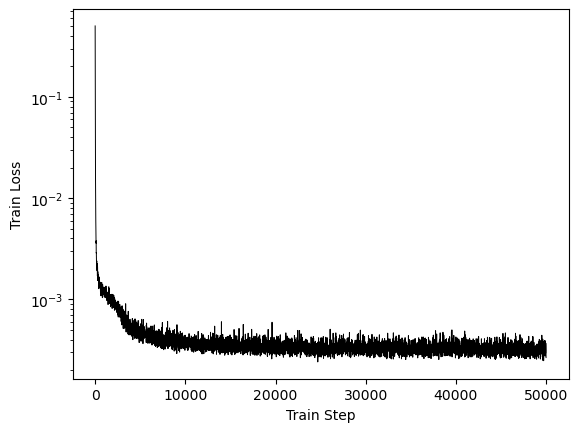

In [9]:
plt.semilogy(np.arange(0, train_steps, 10), loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [10]:
# Evaluate on 2x2 grid
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x, y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)

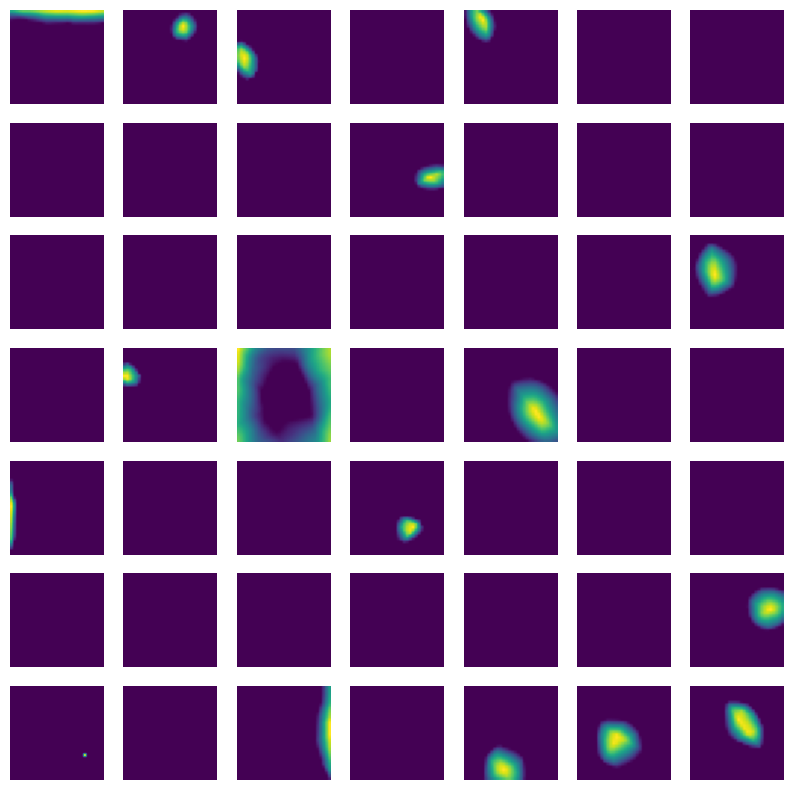

In [11]:
c = -1

# Create context
# context = torch.tensor(np.ones(len(u)), dtype = torch.float32)
# context[u[:, 0] > 0] = -1

context = c*torch.tensor(np.ones(len(u)), dtype = torch.float32)

# Create input
inputs = torch.cat((u, context[...,None]), dim = -1)

# Get spatial representations
p = model.spatial_representation(inputs)
p = p.detach().numpy()

# Todo not sure why I have to swap axes here
p = np.swapaxes(p.T.reshape(-1, n, n), 2, 1) # reshape to (n_out, n, n)

# Get mask of active units
# mask = np.sum(p, axis=(1, 2)) > 0
# p = p[mask]

# Plot ratemaps
fig, ax = ratemap_collage(p[:49], cols=7, figsize=(10, 10))
plt.savefig("figures/bipartite_context")

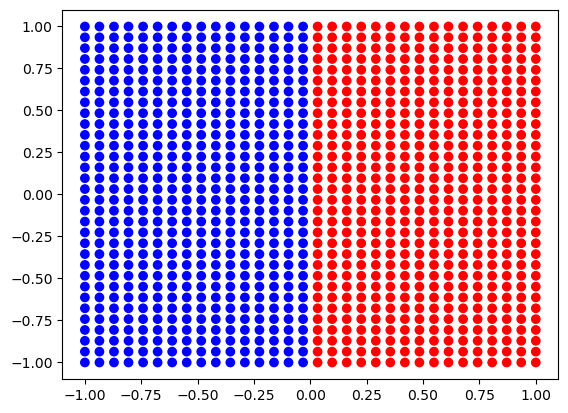

In [15]:
color = np.full(context.shape, 'blue')
color[context == -1] = 'red'
plt.scatter(*u[:,].T, c=color)

### RNN

In [2]:
## Training parameters
train_steps = 50000
timesteps = 10
bs = 32 # batch size

# Model parameters
n_in = 3 # Cartesian coordinates + 1 context
n_out = 100 # no. of spatial representations
scale = 0.15

In [5]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in=n_in, n_out=n_out, corr_across_space=True, scale=scale, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [6]:
genny = SimpleDatasetMaker()  # use simple dataset
train_history = []
progress = tqdm(range(train_steps))
for i in progress:  # train loop
    r, v = genny.generate_dataset(bs, timesteps, device=device)

    # c = torch.ones((bs, timesteps - 1, 1), device=device, dtype=torch.float32)
    # c[r[:, 1:, 0] > 0] = -1

    # Broadcast same context signal to all timesteps
    c = torch.tensor(np.random.uniform(-5, 5, bs), dtype = torch.float32, device=device)
    c = c[:,None,None]*torch.ones((1, timesteps - 1, 1), device = device)

    inputs = (torch.cat((v, c), dim=-1), r[:, 0])
    labels = (r[:, 1:], c)

    loss = model.train_step(x=inputs, y=labels, optimizer=optimizer)

    if i % 10 == 0:
        train_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.020907: 100%|██████████| 50000/50000 [05:56<00:00, 140.06it/s]


Text(0, 0.5, 'Train Loss')

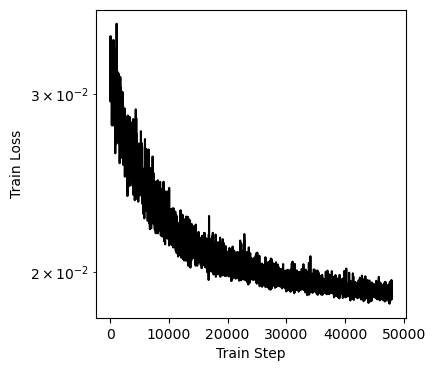

In [65]:
plt.figure(figsize=(4,4))
train_history = train_history[200:]
plt.semilogy(np.arange(len(train_history))*10, train_history, "-k")
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

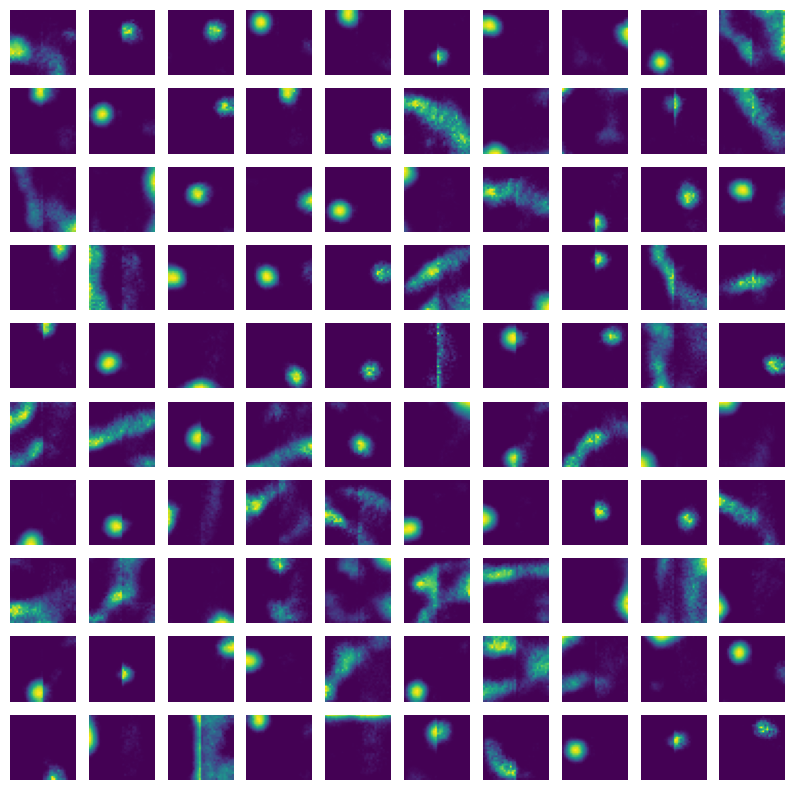

In [66]:
# visualize representations
n_plot = 5000 # number of plot trajectories
n_show = 100 # number of units to show
r, v = genny.generate_dataset(n_plot, timesteps)

# BSR
c = torch.ones(n_plot, timesteps-1, 1) # eval context value
c[r[:, 1:, 0] > 0] = 0
input = torch.cat((v, c), dim = -1)

p,_ = model.spatial_representation(input, model.p0(r[:,0])[None])
p = p.detach().numpy()
ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)
fig, ax = ratemap_collage(ratemaps[:n_show], cols=int(np.sqrt(n_show)), figsize=(10, 10))
#plt.savefig(f"{save_loc}/rnn_representations")

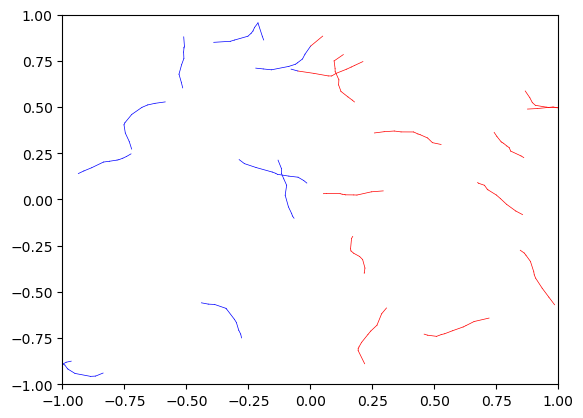

In [68]:
r_numpy = r.detach().numpy()

# Identify the indices where the first dimension is greater than 0
color_mask = r_numpy[:, :, 0] > 0

# Create an array of the same shape as color_mask filled with 'blue'
color = np.full(color_mask.shape, 'blue')

# Update the values where color_mask is True to 'red'
color[color_mask] = 'red'

to_plot = r_numpy[:20].T

# Since plt.plot() doesn't natively support array-like colors, plot lines one by one
for i in range(to_plot.shape[2]):
    for j in range(to_plot.shape[1]-1):
        plt.plot(to_plot[0, j:j+2, i], to_plot[1, j:j+2, i], color=color[i, j], lw=0.5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

### RNN with context in initial state

In [15]:
## Training parameters
train_steps = 50000
timesteps = 10
bs = 32 # batch size

# Model parameters
n_in = 3 # Cartesian coordinates + 1 context
n_out = 100 # no. of spatial representations
scale = 0.15

In [16]:
# Instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in=n_in, n_out=n_out, corr_across_space=True, scale=scale, device=device, initial_state_size=3)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [23]:
genny = SimpleDatasetMaker()  # use simple dataset
train_history = []
progress = tqdm(range(train_steps))
for i in progress:  # train loop

    # Generate dataset
    r, v = genny.generate_dataset(bs, timesteps, device=device)

    # Broadcast same context signal to all timesteps
    c = torch.tensor(np.random.uniform(-5, 5, bs), dtype = torch.float32, device=device)
    c = c[:,None,None]*torch.ones((1, timesteps - 1, 1), device = device)

    # Build initial input
    initial_input = torch.cat((r[:, 0], c[:, 0]), dim=-1)

    inputs = (torch.cat((v, c), dim=-1), initial_input)
    labels = (r[:, 1:], c)

    loss = model.train_step(x=inputs, y=labels, optimizer=optimizer)

    if i % 10 == 0:
        train_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.020094: 100%|██████████| 50000/50000 [08:16<00:00, 100.70it/s]


Text(0, 0.5, 'Train Loss')

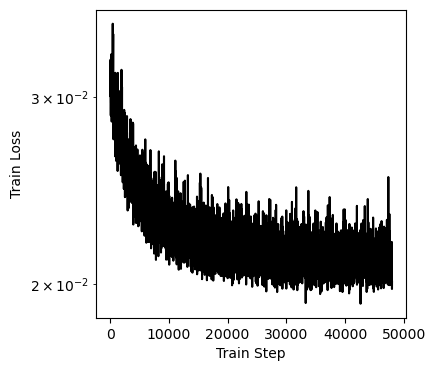

In [25]:
plt.figure(figsize=(4,4))
train_history = train_history[200:]
plt.semilogy(np.arange(len(train_history))*10, train_history, "-k")
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

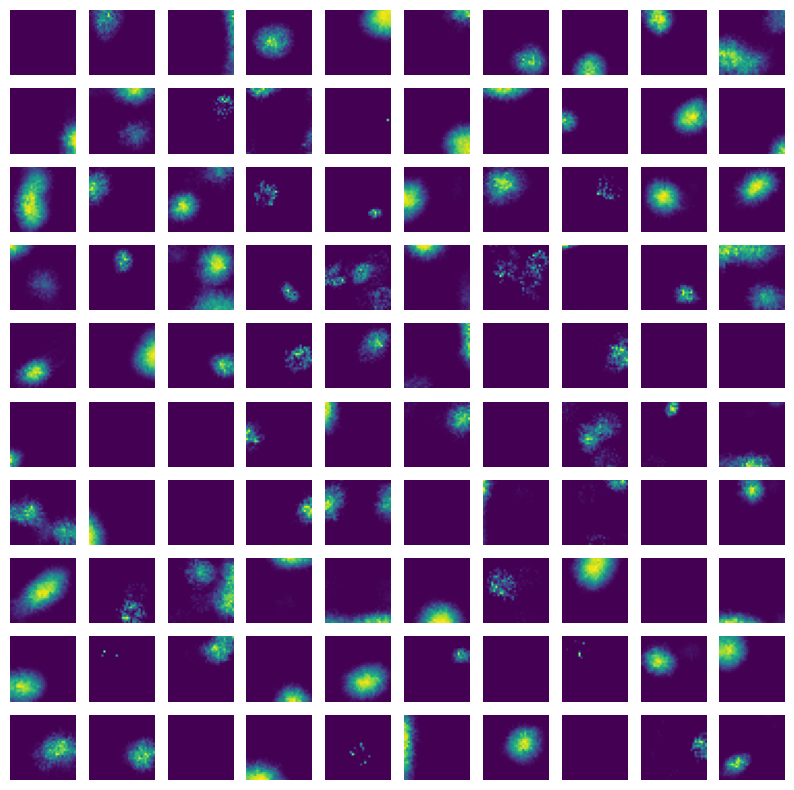

In [27]:
# visualize representations
n_plot = 5000 # number of plot trajectories
n_show = 100 # number of units to show
r, v = genny.generate_dataset(n_plot, timesteps)

# BSR
# c = torch.ones(n_plot, timesteps-1, 1) # eval context value
# c[r[:, 1:, 0] > 0] = 0

c = 3 # eval context value
c = c*torch.ones(n_plot, timesteps-1, 1)

input = torch.cat((v, c), dim=-1)
initial_input = torch.cat((r[:, 0], c[:, 0]), dim=-1)

p,_ = model.spatial_representation(input, model.p0(initial_input)[None])
p = p.detach().numpy()
ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)
fig, ax = ratemap_collage(ratemaps[:n_show], cols=int(np.sqrt(n_show)), figsize=(10, 10))
#plt.savefig(f"{save_loc}/rnn_representations")

### RNN with context switch along the way

In [59]:
## Training parameters
train_steps = 50000
timesteps = 10
bs = 32 # batch size

# Model parameters
n_in = 3 # Cartesian coordinates + 1 context
n_out = 100 # no. of spatial representations
scale = 0.15

In [60]:
# Instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in=n_in, n_out=n_out, corr_across_space=True, scale=scale, device=device, initial_state_size=3)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [61]:
def get_context(timesteps, bs, device):
    """
    Generate a context signal for a batch of trajectories that may or may not change along the way.
    """

    # Initialize the tensor
    c = torch.empty(bs, timesteps, 1)

    # Populate the tensor
    for i in range(bs):

        # Decide if context changes for this trajectory
        context_changes = torch.randint(0, 2, (1,)).item()

        if context_changes:
            # Decide the point of change
            change_point = torch.randint(2, timesteps-2, (1,)).item()

            # Decide initial context value, it will be flipped at the change_point
            initial_value = torch.randint(0, 2, (1, 1)) * 2 - 1
            c[i, :change_point] = initial_value
            c[i, change_point:] = -initial_value
        else:
            # If context doesn't change, fill the entire trajectory with either -1 or 1
            constant_value = torch.randint(0, 2, (1, 1)) * 2 - 1
            c[i].fill_(constant_value.item())


    return c.to(device)

In [63]:
genny = SimpleDatasetMaker()  # use simple dataset
train_history = []
progress = tqdm(range(train_steps))
for i in progress:  # train loop

    # Generate dataset
    r, v = genny.generate_dataset(bs, timesteps, device=device)

    # Get context signal
    c = get_context(timesteps-1, bs, device)

    # Build initial input
    initial_input = torch.cat((r[:, 0], c[:, 0]), dim=-1)

    inputs = (torch.cat((v, c), dim=-1), initial_input)
    labels = (r[:, 1:], c)

    loss = model.train_step(x=inputs, y=labels, optimizer=optimizer)

    if i % 10 == 0:
        train_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.020574: 100%|██████████| 50000/50000 [11:25<00:00, 72.93it/s] 


Text(0, 0.5, 'Train Loss')

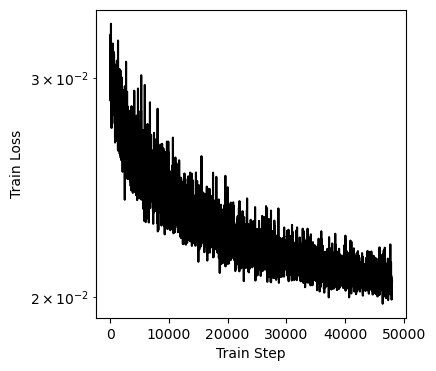

In [64]:
plt.figure(figsize=(4,4))
train_history = train_history[200:]
plt.semilogy(np.arange(len(train_history))*10, train_history, "-k")
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

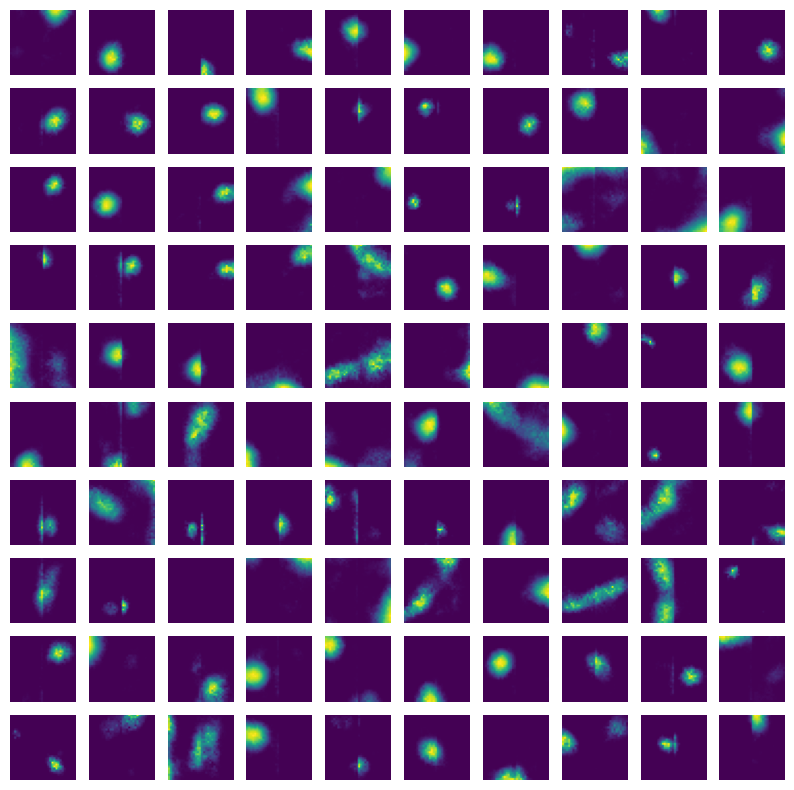

In [69]:
# visualize representations
n_plot = 5000 # number of plot trajectories
n_show = 100 # number of units to show
r, v = genny.generate_dataset(n_plot, timesteps)

# BSR
c = torch.ones(n_plot, timesteps-1, 1) # eval context value
c[r[:, 1:, 0] > 0] = 0

# c = 1 # eval context value
# c = c*torch.ones(n_plot, timesteps-1, 1)
# c = get_context(timesteps-1, n_plot, device)

input = torch.cat((v, c), dim=-1)
initial_input = torch.cat((r[:, 0], c[:, 0]), dim=-1)

p,_ = model.spatial_representation(input, model.p0(initial_input)[None])
p = p.detach().numpy()
ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)
fig, ax = ratemap_collage(ratemaps[:n_show], cols=int(np.sqrt(n_show)), figsize=(10, 10))
#plt.savefig(f"{save_loc}/rnn_representations")

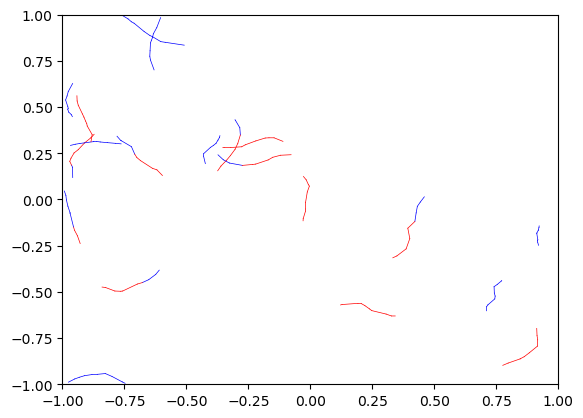

In [67]:
r_numpy = r.detach().numpy()

# Identify the indices where the first dimension is greater than 0
color_mask = c[:, :, 0] > 0

# Create an array of the same shape as color_mask filled with 'blue'
color = np.full(color_mask.shape, 'blue')

# Update the values where color_mask is True to 'red'
color[color_mask] = 'red'

to_plot = r_numpy[:20].T

# Since plt.plot() doesn't natively support array-like colors, plot lines one by one
for i in range(to_plot.shape[2]):
    for j in range(to_plot.shape[1]-1):
        plt.plot(to_plot[0, j:j+2, i], to_plot[1, j:j+2, i], color=color[i, j], lw=0.5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()